Optimizando Gamma para: Scale Pos Weight...
Optimizando Gamma para: SMOTE + Tomek...
Optimizando Gamma para: SMOTE + ENN...
Optimizando Gamma para: NearMiss...
Optimizando Gamma para: ADASYN...


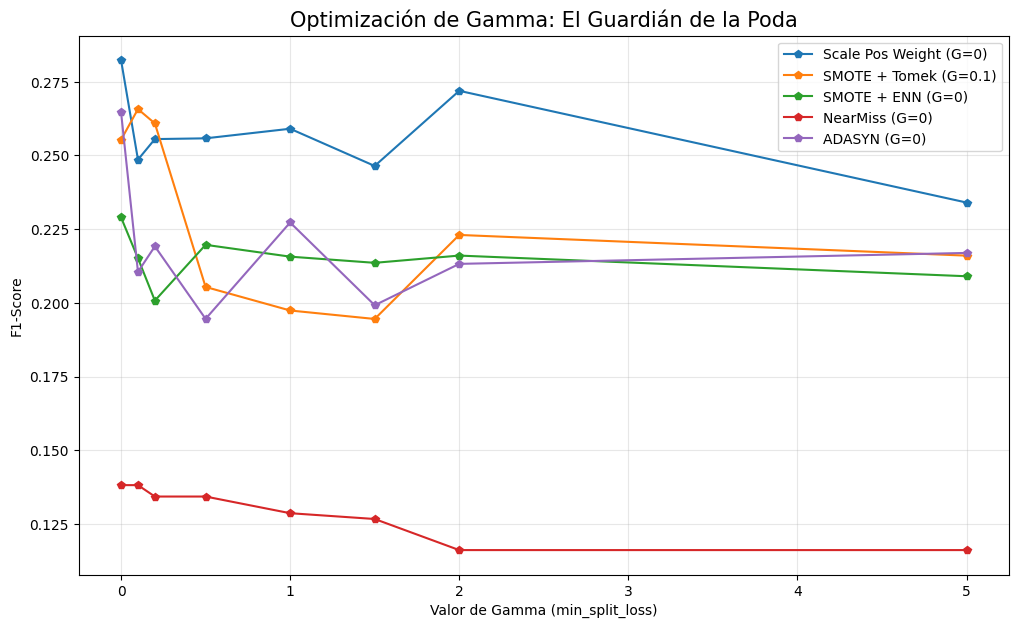


TÉCNICA              | BEST GAMMA | MAX F1  
------------------------------------------------------------
Scale Pos Weight     | 0          | 0.2824
SMOTE + Tomek        | 0.1        | 0.2657
SMOTE + ENN          | 0          | 0.2290
NearMiss             | 0          | 0.1382
ADASYN               | 0          | 0.2647


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ratio_balanceo = float(np.sum(y_train == 0) / np.sum(y_train == 1))

# 2. Configuración Maestra (Fases 1 a 4)
# {Nombre: (Sampler, n_est, lr, depth, child_weight)}
config_fase4 = {
    'Scale Pos Weight': (None, 125, 0.1, 5, 1),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15, 5, 3),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1, 5, 1),
    'NearMiss': (NearMiss(), 271, 0.001, 4, 1),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15, 5, 1)
}

gamma_range = [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 5]
gamma_results = []

plt.figure(figsize=(12, 7))

for nombre, (sampler, n_opt, lr_opt, d_opt, w_opt) in config_fase4.items():
    gammas_f1 = []
    
    if nombre == 'Scale Pos Weight':
        X_res, y_res = X_train, y_train
        spw = ratio_balanceo
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        spw = 1
        
    print(f"Optimizando Gamma para: {nombre}...")
    
    for g in gamma_range:
        model = XGBClassifier(
            n_estimators=n_opt,
            learning_rate=lr_opt,
            max_depth=d_opt,
            min_child_weight=w_opt,
            gamma=g,
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        gammas_f1.append(f1_score(y_test, y_pred))
    
    # Obtener mejor gamma
    max_f1 = max(gammas_f1)
    best_g = gamma_range[gammas_f1.index(max_f1)]
    gamma_results.append({
        'Técnica': nombre,
        'Best Gamma': best_g,
        'Max F1': max_f1
    })
    
    plt.plot(gamma_range, gammas_f1, marker='p', label=f"{nombre} (G={best_g})")

plt.title('Optimización de Gamma: El Guardián de la Poda', fontsize=15)
plt.xlabel('Valor de Gamma (min_split_loss)')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Reporte Final de la Fase 5
print("\n" + "="*60)
print(f"{'TÉCNICA':<20} | {'BEST GAMMA':<10} | {'MAX F1':<8}")
print("-"*60)
for r in gamma_results:
    print(f"{r['Técnica']:<20} | {r['Best Gamma']:<10} | {r['Max F1']:.4f}")
print("="*60)